# OpenAPS Exponential Insulin Activity and IOB Calculations
----
This notebook will replicate and visualize the calculation of insulin `activity` and `iob` used in the development branch for the next official release in the [OpenAPS project](https://github.com/openaps/oref0).

Specifically, it will replicate the javascript code found in [oref0/lib/iob/calculate.js](https://github.com/openaps/oref0/blob/dev/lib/iob/calculate.js) and plot the insulin `activity` curves and `iob` curves for a set of `dia` and `peak` values.

### First, some definitions:
* **dia:** Duration of Insulin Activity. This is the user specified time (in hours) that insulin lasts in their body after a bolus. This value comes from the user's pump settings. 


* **end:** Duration (in minutes) that insulin is active. `end` = `dia` * 60.


* **peak:** Duration (in minutes) when insulin action it's peak activity level.


* **activity:** The percentage of insulin that was active in the previous minute. 

    **Note:** The neither the code in the [master branch version of oref0/lib/iob/calculation.js](https://github.com/openaps/oref0/blob/master/lib/iob/calculate.js) or the code in the [dev branch version of oref0/lib/iob/calculation.js](https://github.com/openaps/oref0/blob/dev/lib/iob/calculate.js) calculates a variable called `activity`. Instead, it calculates a variable called `activityContrib`, which is I've broken into its two components: `activity` and `treatment.insulin`. I analyze `activity`, which is just the scaling factor applied to `treatment.insulin`.


In [1]:
import pandas as pd
import numpy as np
import math as Math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def calc_exp_activity(minutes_to_peak):
    
    minutes_to_end = 300 # minutes
    
    peak_to_end = float(minutes_to_peak) / float(minutes_to_end)
    
    tau = (1.0 * minutes_to_peak) * (1 - peak_to_end) / (1 - 2 * peak_to_end)
    a = 2 * tau / (1.0 * minutes_to_end);
    S = 1 / (1 - a + (1 + a) * Math.exp(-(1.0 * minutes_to_end) / tau));
    
    
    #print peak_to_end
    #print tau
    #print a
    #print S
    
    x_list = []
    activity_list = [] 
    iob_list = []
    
    for i_min in range(0, minutes_to_end + 1):  # Add 1 to get plot at the last minute
                
        if (i_min < minutes_to_end + 1):   # Add 1 to get plot at the last minute
            x_list.append(i_min)
            
            activity = (S / Math.pow(tau, 2)) * i_min * (1 - i_min / (float(minutes_to_end))) * Math.exp(-i_min / tau)
            activity_list.append(activity)
            
            iob = (1 - S * (1 - a) * ((Math.pow(i_min, 2) / (tau * minutes_to_end * (1 - a)) - i_min / tau - 1) * Math.exp(-i_min / tau) + 1))
            iob_list.append(iob)
            
    return x_list, activity_list, iob_list

In [3]:
# Create a dictionary of DataFrames -- one for each value of DIA between 2 and 8
dict_of_dfs_by_peak = {}

for peak in range(60, 130, 5):                           # Note: range() ends at n-1
    x_list, activity_list, iob_list = calc_exp_activity(peak)
    activity_df = pd.DataFrame({'x' : x_list, 'activity_peak_' + str(peak) : activity_list, 'iob_peak_' + str(peak) : iob_list})
    
    # Add a cummulative sum column for activity
    activity_df['cum_activity_peak_' + str(peak)] = activity_df['activity_peak_' + str(peak)].cumsum()
   
    # Put df into a dictionary with dia as the key
    dict_of_dfs_by_peak.update({peak : activity_df})

In [4]:
dict_of_dfs_by_peak[75].head()

,activity_peak_75,iob_peak_75,x,cum_activity_peak_75
0,0.000000,1.000000,0,0.000000
1,0.000210,0.999895,1,0.000210
2,0.000415,0.999582,2,0.000625
3,0.000615,0.999066,3,0.001240
4,0.000810,0.998353,4,0.002050


In [5]:
dict_of_dfs_by_peak[75].tail()

,activity_peak_75,iob_peak_75,x,cum_activity_peak_75
296,0.000060,1.199543e-04,296,0.999891
297,0.000045,6.722575e-05,297,0.999936
298,0.000030,2.976795e-05,298,0.999966
299,0.000015,7.414518e-06,299,0.999981
300,0.000000,1.110223e-16,300,0.999981


In [6]:
# Peak activity 
dict_of_dfs_by_peak[75].iloc[74:77, :]

,activity_peak_75,iob_peak_75,x,cum_activity_peak_75
74,0.006140,0.678780,74,0.324272
75,0.006141,0.672640,75,0.330413
76,0.006140,0.666499,76,0.336553


## Plot the Activity Curves!

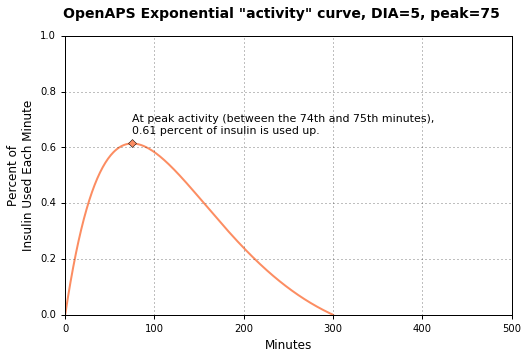

In [7]:
# Plot activity curve for just (peak == 75)
plt.figure(figsize=(8, 5))
plt.ylabel('Percent of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS Exponential "activity" curve, DIA=5, peak=75', fontsize=14, fontweight='bold')

markers = [75]

act_75_pct = dict_of_dfs_by_peak[75]['activity_peak_75'] * 100
act_75_pct.plot(kind='line', 
                label='peak=75', 
                color='#fc8d62', 
                linewidth=2,
                marker='D', 
                markevery=markers).grid(True)

plt.text(75, 0.65, 'At peak activity (between the 74th and 75th minutes),\n0.61 percent of insulin is used up.', fontsize=11)
#plt.text(140, 0.54, 'At two hours (between the 119th and 120th minutes),\n 0.62 percent of insulin is used up.', fontsize=11)

plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5, width=1)

plt.xlim([0,500])
plt.ylim([0,1.0])

#plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.0)

plt.savefig('..\output\OpenAPS_exponential_activity_curve_dia_5_peak_75.png', format='png', dpi=600)

plt.show()

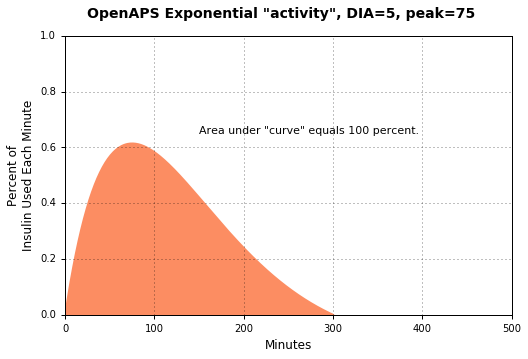

In [8]:
# Plot activity AREA UNDER curve 
plt.figure(figsize=(8, 5))
plt.ylabel('Percent of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS Exponential "activity", DIA=5, peak=75', fontsize=14, fontweight='bold')

# Create df with data in percentages
act_peak_75 = dict_of_dfs_by_peak[75]['activity_peak_75'] * 100 

ax_line = act_peak_75.plot(kind='line', 
                           label='DIA=5', 
                           color='#fc8d62', 
                           linewidth=2,).grid(True)
ax_bar = act_peak_75.plot(kind='bar', 
                          edgecolor="none", 
                          width=1, 
                          label='Area under "curve"', 
                          color='#fc8d62').grid(True)

plt.text(150, 0.65, 'Area under "curve" equals 100 percent.' , fontsize=11)
plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5, width=1)

plt.xlim([0,500])
plt.xticks(np.arange(0,501,100), ('0', '100', '200', '300', '400', '500'), rotation='horizontal')
plt.ylim([0,1.0])

#plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.0)

plt.savefig('..\output\OpenAPS_exponential_activity_curve_dia_5_peak_75_area.png', format='png', dpi=600)

plt.show()

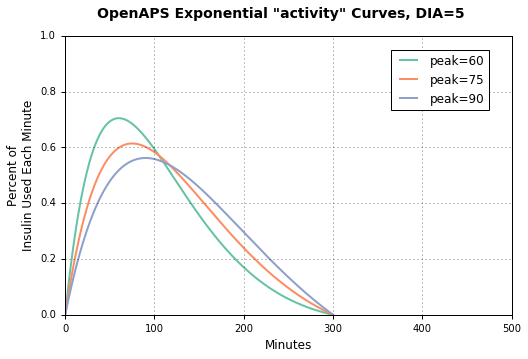

In [9]:
# Plot activity curve for dia = 5, peak = [60, 75, 90]
plt.figure(figsize=(8, 5))
plt.ylabel('Percent of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS Exponential "activity" Curves, DIA=5', fontsize=14, fontweight='bold')

#colors = {60:'#d1b26f', 75:'#653700', 90:'#6e750e'}
#colors = {60:'#b3e2cd',75:'#fdcdac',90:'#cbd5e8'}
colors = {60:'#66c2a5',75:'#fc8d62',90:'#8da0cb'}

for peak in [60, 75, 90]:
    peak_str = str(peak)
    (dict_of_dfs_by_peak[peak]['activity_peak_' + peak_str]*100).plot(kind='line', 
                                                                      color=colors[peak], 
                                                                      linewidth=2, 
                                                                      label='peak=' + peak_str).grid(True)

plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5, width=1)    
    
plt.xlim([0,500])
plt.ylim([0,1.0])

plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.)

plt.savefig('..\output\OpenAPS_exponential_activity_curves_dia_5_peak_60_75_90.png', format='png', dpi=600)

plt.show()  

## Plot the Cumulative Activity Curves!

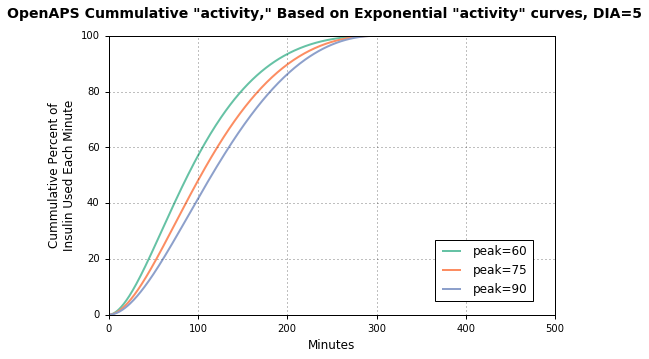

In [10]:
# Plot cumulative activity curves for dia = 5, peak = [60, 75, 90]
plt.figure(figsize=(8, 5))
plt.ylabel('Cummulative Percent of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS Cummulative "activity," Based on Exponential "activity" curves, DIA=5', fontsize=14, fontweight='bold')

colors = {60:'#66c2a5',75:'#fc8d62',90:'#8da0cb'}

for peak in [60, 75, 90]:
    peak_str = str(peak)
    (dict_of_dfs_by_peak[peak]['cum_activity_peak_' + peak_str]*100).plot(kind='line', 
                                                                          color=colors[peak], 
                                                                          linewidth=2, 
                                                                          label='peak=' + peak_str).grid(True)
    
    
plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5, width=1)
    
plt.xlim([0,500])
plt.ylim([0,100])
    
plt.legend(bbox_to_anchor=(0.95, 0.05), loc=4, borderaxespad=0.)

plt.savefig('..\output\OpenAPS_exponential_cum_activity_curves_dia_5_peak_60_75_90.png', format='png', dpi=600)

plt.show()  

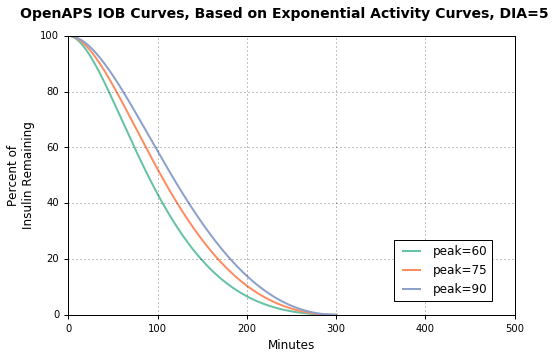

In [11]:
# Plot iob curves for dia = 5, peak = [60, 75, 90]
plt.figure(figsize=(8, 5))
plt.ylabel('Percent of\nInsulin Remaining', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS IOB Curves, Based on Exponential Activity Curves, DIA=5', fontsize=14, fontweight='bold')

colors = {60:'#66c2a5',75:'#fc8d62',90:'#8da0cb'}

for peak in [60, 75, 90]:
    peak_str = str(peak)
    (dict_of_dfs_by_peak[peak]['iob_peak_' + peak_str]*100).plot(kind='line', 
                                                                 color=colors[peak],
                                                                 linewidth=2,
                                                                 label='peak=' + peak_str).grid(True)

    
plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5, width=1)
    
plt.xlim([0,500])
plt.ylim([0,100])
    
plt.legend(bbox_to_anchor=(0.95, 0.05), loc=4, borderaxespad=0.)

plt.savefig('..\output\OpenAPS_exponential_iob_curves_dia_5_peak_60_75_90.png', format='png', dpi=600)

plt.show()  

## Calculate activity and IOB using bilinear version of activity formula for DIA=5

In [12]:
def calc_activity(dia):
    
    peak = 75 # minutes
    end = 180 # minutes
    
    x_list = []
    activity_list = [] 
    
    for i_min in range(0, (dia * 60) + 1):  # Add 1 to get plot at the last minute
        
        i_min = i_min * 3.0 / dia
        
        if (i_min < peak):
            x = (i_min / 5) + 1.0
            x_list.append(x)
            
            activity = (2.0 / dia / 60 / peak) * i_min  # Note: 2.0 needs a decimal representation to cast activity into a float.
            activity_list.append(activity)
            
        elif (i_min < end + 1):             # Add 1 to get plot at the last minute
            x = (i_min - peak) / 5 # Also, why / 5? Is this b/c the coefficients were estimated in 5 min intervals?
            x_list.append(x)
            
            activity = (2.0 / dia / 60 - (i_min - peak) * 2 / dia / 60 / (60 * 3 - peak))
            activity_list.append(activity)
    
    return x_list, activity_list   

In [13]:
# Create a dictionary of DataFrames -- one for each value of DIA between 2 and 8
dict_of_dfs_by_dia = {}

for dia in range(2, 9):                           # Note: range() ends at n-1
    x_list, activity_list = calc_activity(dia)
    activity_df = pd.DataFrame({'x' : x_list, 'activity_dia_' + str(dia) : activity_list})
    
    # Add a cummulative sum column for activity
    activity_df['cum_activity_dia_' + str(dia)] = activity_df['activity_dia_' + str(dia)].cumsum()
   
    # Put df into a dictionary with dia as the key
    dict_of_dfs_by_dia.update({dia : activity_df})

In [14]:
dict_of_dfs_by_dia[5].head()

,activity_dia_5,x,cum_activity_dia_5
0,0.000000,1.00,0.000000
1,0.000053,1.12,0.000053
2,0.000107,1.24,0.000160
3,0.000160,1.36,0.000320
4,0.000213,1.48,0.000533


In [15]:
dict_of_dfs_by_dia[5].tail()

,activity_dia_5,x,cum_activity_dia_5
296,1.523810e-04,20.52,0.999771
297,1.142857e-04,20.64,0.999886
298,7.619048e-05,20.76,0.999962
299,3.809524e-05,20.88,1.000000
300,8.673617e-19,21.00,1.000000


## Plot the Activity Curve, DIA = 5

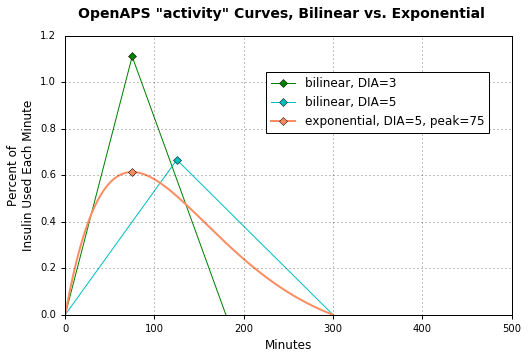

In [16]:
# Plot activity curve for just (dia == 5)
plt.figure(figsize=(8, 5))
plt.ylabel('Percent of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS "activity" Curves, Bilinear vs. Exponential', fontsize=14, fontweight='bold')

markers = [75]
bilinear_marker = [125]

act_3_pct = dict_of_dfs_by_dia[3]['activity_dia_3'] * 100
act_3_pct.plot(kind='line', label='bilinear, DIA=3', color='g', markevery=markers, marker='D').grid(True)

act_5_pct = dict_of_dfs_by_dia[5]['activity_dia_5'] * 100
act_5_pct.plot(kind='line', label='bilinear, DIA=5', color='c', markevery=bilinear_marker, marker='D').grid(True)

act_75_pct = dict_of_dfs_by_peak[75]['activity_peak_75'] * 100
act_75_pct.plot(kind='line', 
                label='exponential, DIA=5, peak=75', 
                color='#fc8d62', 
                linewidth=2,
                markevery=markers, 
                marker='D').grid(True)

                #markersize=6,
                #markeredgecolor='k',
                #markeredgewidth=1.0

plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5, width=1)

plt.xlim([0,500])
plt.ylim([0,1.2])

plt.legend(bbox_to_anchor=(0.95, 0.87), loc=1, borderaxespad=0.0, numpoints=1)

plt.savefig('..\output\OpenAPS_activity_curves_bilinear_vs_exponential.png', format='png', dpi=600)

plt.show()

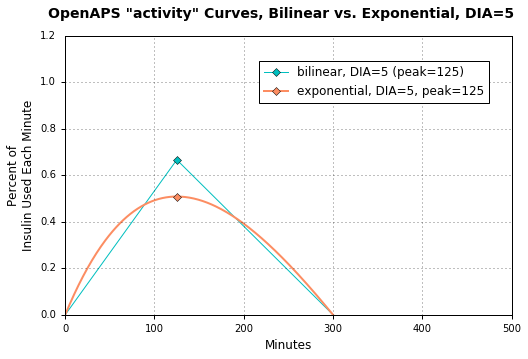

In [17]:
# Plot activity curve for just (dia == 5)
plt.figure(figsize=(8, 5))
plt.ylabel('Percent of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS "activity" Curves, Bilinear vs. Exponential, DIA=5', fontsize=14, fontweight='bold')

markers = [125]

act_5_pct = dict_of_dfs_by_dia[5]['activity_dia_5'] * 100
act_5_pct.plot(kind='line', 
               label='bilinear, DIA=5 (peak=125)', 
               color='c', 
               markevery=bilinear_marker, 
               marker='D').grid(True)

act_75_pct = dict_of_dfs_by_peak[125]['activity_peak_125'] * 100
act_75_pct.plot(kind='line', 
                label='exponential, DIA=5, peak=125', 
                color='#fc8d62', 
                linewidth=2,
                markevery=markers, 
                marker='D').grid(True)

plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5, width=1)

plt.xlim([0,500])
plt.ylim([0,1.2])

plt.legend(bbox_to_anchor=(0.95, 0.91), loc=1, borderaxespad=0.0, numpoints=1)

plt.savefig('..\output\OpenAPS_activity_curves_bilinear_vs_exponential_dia_5.png', format='png', dpi=600)

plt.show()

## Calculate IOB based on bilinear "curves", for DIA=5

In [18]:
def calc_IOB(dia):
    
    # Coefficients used in estimating the percent of insulin remaining, or (alternatively) the insulin action/decay curve.
    # Coeff[0] = alpha * 1
    # Coeff[1] = beta1 * x^2
    # Coeff[2] = beta2 * x
    insulin_action_coeffs = [[1.000000, -0.001852, 0.001852],   # Applied between [0,peak)
                             [0.555560, 0.001323, -0.054233]]   # Applied between [peak,end]
    # Source: ?????
    
    peak = 75
    end = 180
    
    x_list = []
    iob_list = [] 
    act_list = []
    
    for i_min in range(0, dia * 60):
        
        if (i_min > 0):
            i_min_minus1 = i_min - 1
        else:
            i_min_minus1 = i_min
            
        i_min = i_min * 3.0 / dia
        i_min_minus1 = i_min_minus1 * 3.0 / dia
        
        if (i_min < peak):
            x = (i_min / 5) + 1 # Why + 1? Should there be a (i_min == 0) condition that returns iob_pct = 1?
            x_list.append(x)
            
            # Calculation used in OpenAPS
            iob_pct = (insulin_action_coeffs[0][0] + insulin_action_coeffs[0][1] * x**2 + insulin_action_coeffs[0][2] * x)
            iob_list.append(iob_pct)
            
            x_minus1 = (i_min_minus1 / 5) + 1
            
            # Calculation of 'activity' based on IOBt-1 - IOBt
            act = (insulin_action_coeffs[0][0] + insulin_action_coeffs[0][1] * x_minus1**2 + insulin_action_coeffs[0][2] * x_minus1) - iob_pct
            act_list.append(act)
            
        elif (i_min < end):
            x = (i_min - peak) / 5 # Also, why / 5? Is this just b/c the coefficients were estimated in 5 min intervals?
            x_list.append(x)
            
            iob_pct = insulin_action_coeffs[1][0] + insulin_action_coeffs[1][1] * x**2 + insulin_action_coeffs[1][2] * x
            iob_list.append(iob_pct)

            x_minus1 = (i_min_minus1 - peak) / 5 
            
            act = (insulin_action_coeffs[1][0] + insulin_action_coeffs[1][1] * x_minus1**2 + insulin_action_coeffs[1][2] * x_minus1) - iob_pct
            act_list.append(act)
    
    return x_list, iob_list, act_list   

In [19]:
# Create a dictionary of DataFrames -- one for each value of DIA between 2 and 8
dict_of_iob_dfs_by_dia = {}

for dia in range(2, 9):                           # NB: range() ends at n-1
    x_list, iob_list, act_list = calc_IOB(dia)
    iob_df = pd.DataFrame({'x' : x_list, 'iob_pct_dia_' + str(dia) : iob_list, 'activity_dia_' + str(dia) : act_list})
    dict_of_iob_dfs_by_dia.update({dia : iob_df})

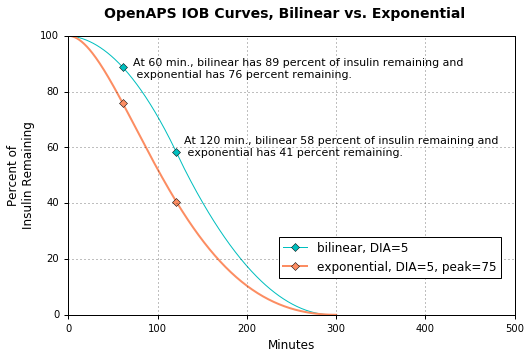

In [20]:
# Now plot the curves
plt.figure(figsize=(8, 5))

plt.ylabel('Percent of\nInsulin Remaining', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS IOB Curves, Bilinear vs. Exponential', fontsize=14, fontweight='bold')

markers = [61, 121]

iob_pct_5 = dict_of_iob_dfs_by_dia[5]['iob_pct_dia_5'] * 100
iob_pct_5.plot(kind='line', label='bilinear, DIA=5', color='c', markevery=markers, marker='D').grid(True)

iob_exp_5_75 = dict_of_dfs_by_peak[75]['iob_peak_75'] * 100
iob_exp_5_75.plot(kind='line', 
                  label='exponential, DIA=5, peak=75', 
                  color='#fc8d62',
                  linewidth=2,
                  markevery=markers, 
                  marker='D').grid(True)

plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5, width=1)

plt.text(72, 85, 'At 60 min., bilinear has 89 percent of insulin remaining and\n exponential has 76 percent remaining.' , fontsize=11)
plt.text(130, 57, 'At 120 min., bilinear 58 percent of insulin remaining and\n exponential has 41 percent remaining.' , fontsize=11)


plt.legend(bbox_to_anchor=(0.97, 0.28), loc=1, borderaxespad=0.0, numpoints=1)
plt.savefig('..\output\OpenAPS_iob_curves_bilinear_vs_exponential.png', format='png', dpi=600)

plt.xlim([0,500])
plt.ylim([0,100])

plt.show()   

In [21]:
# Activity using exponential curve (dia=5, peak=75) at 60 minutes
dict_of_dfs_by_peak[75].iloc[61, :]

activity_peak_75         0.006008
iob_peak_75              0.758008
x                       61.000000
cum_activity_peak_75     0.244980
Name: 61, dtype: float64

In [22]:
# Activity using exponentical curve (dia=5, peak=75) at 120 minutes
dict_of_dfs_by_peak[75].iloc[121, :]

activity_peak_75          0.005236
iob_peak_75               0.405327
x                       121.000000
cum_activity_peak_75      0.597270
Name: 121, dtype: float64

In [23]:
# Activity using bilinear curve (dia=5) at 160 minutes
dict_of_iob_dfs_by_dia[5].iloc[61, :]

activity_dia_5    0.003449
iob_pct_dia_5     0.887209
x                 8.320000
Name: 61, dtype: float64

In [24]:
# Activity using bilinear curve (dia=5) at 120 minutes
dict_of_iob_dfs_by_dia[5].iloc[121, :]

activity_dia_5     0.006649
iob_pct_dia_5      0.582651
x                 15.520000
Name: 121, dtype: float64

# The End!!!

Well, OK... Not quite...

Gonna make some example graphs of exponential growth and exponential decay

In [110]:
from math import exp
def exp_growth(t):
    return exp(t/60)

def exp_decay(t):
    return 1000 * exp(-t/60)

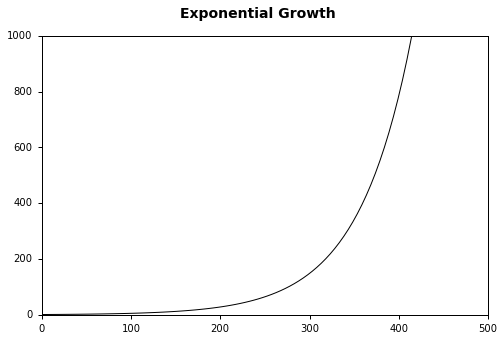

In [111]:
# Plot the exponential growth and decay curves
plt.figure(figsize=(8, 5))


x1 = np.linspace(0,500, num=100)
y1 = np.array([exp_growth(t) for t in x1])

#plt.ylabel('Percent of\nInsulin Used Each Minute', fontsize=12)
#plt.xlabel('Minutes', fontsize=12)
plt.suptitle('Exponential Growth', fontsize=14, fontweight='bold')

plt.plot(x1, y1, 
         label='exp_growth', 
         color='k') #.grid(True)


plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5, width=1)

#plt.xlim([0,500])
plt.ylim([0,1000.0])

#plt.savefig('..\output\OpenAPS_exponential_activity_curve_dia_5_peak_75.png', format='png', dpi=600)

plt.show()

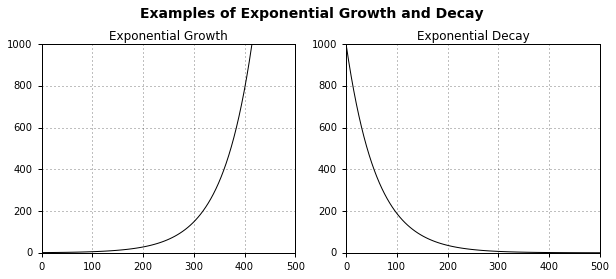

In [117]:
# Plot the exponential growth and decay curves
plt.figure(figsize=(10, 4))


x1 = np.linspace(0,500, num=100)
y1 = np.array([exp_growth(t) for t in x1])

x2 = np.linspace(0,500, num=100)
y2 = np.array([exp_decay(t) for t in x2])

plt.suptitle('Examples of Exponential Growth and Decay', fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.85)

plt.subplot(1, 2, 1)
plt.plot(x1, y1, 
         label='exp_growth', 
         color='k')
plt.title('Exponential Growth') 
plt.grid(True)
plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5, width=1)
#plt.xlim([0,500])
plt.ylim([0,1000.0])

plt.subplot(1, 2, 2)
plt.plot(x2, y2, 
         label='exp_decay', 
         color='k')
plt.title('Exponential Decay') 
plt.grid(True)
plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5, width=1)
#plt.xlim([0,500])
plt.ylim([0,1000.0])

plt.savefig('..\output\example_exponential_growth_and_decay.png', format='png', dpi=600)

plt.show()